In [1]:
using QEDFeynmanDiagrams
using ComputableDAGs
using RuntimeGeneratedFunctions
RuntimeGeneratedFunctions.init(@__MODULE__)
using QEDprocesses
using QEDcore
using DataFrames
using BenchmarkTools

In [2]:
N = 7
compton_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (SpinUp(), ntuple(_ -> PolX(), n)...),         # incoming particle spin/pols
        (SpinUp(), PolX()),                            # outgoing particle spin/pols
    )

    graph_gen_bench = @benchmark generate_DAG($proc_nocombs)
    
    g_nocombs = generate_DAG(proc_nocombs)

    push!(compton_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

compton_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,53774.0,93026.4
2,6,85,238676.0,1.52586e5
3,24,184,1.10167e6,3.06135e5
4,120,395,5.06517e6,6.37025e5
5,720,846,3.50811e7,1.9392e6
6,5040,1809,2.35549e8,7.4163e6
7,40320,3860,1.90305e9,1.90293e7


In [3]:
N = 7
compton_all_sp_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (AllSpin(), ntuple(_ -> AllPol(), n)...),      # incoming particle spin/pols
        (AllSpin(), AllPol()),                         # outgoing particle spin/pols
    )

    graph_gen_bench = @benchmark generate_DAG($proc_allcombs)
    
    g_allcombs = generate_DAG(proc_allcombs)

    push!(compton_all_sp_df, (length(feynman_diagrams(proc_allcombs)) * multiplicity(proc_allcombs), length(g_allcombs.nodes), median(graph_gen_bench.times), std(graph_gen_bench.times)))
end

compton_all_sp_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,32,176,3.888e5,2.62922e5
2,192,642,2.68414e6,5.30533e5
3,1536,2320,1.22517e7,1.28065e6
4,15360,9590,6.65256e7,3.07143e6
5,184320,36876,2.97381e8,1.14726e7
6,2580480,159042,1.64746e9,3.58106e7
7,41287680,625080,8.40144e9,NaN


In [4]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 5
compton_exec_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_nocombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (SpinUp(), ntuple(_ -> PolX(), n)...),         # incoming particle spin/pols
        (SpinUp(), PolX()),                            # outgoing particle spin/pols
    )

    g_nocombs = generate_DAG(proc_nocombs)

    func = get_compute_function(g_nocombs, proc_nocombs, cpu_st(), @__MODULE__)
    
    psp = gen_process_input(RNG, proc_nocombs)
    
    exec_bench = @benchmark $func($psp)

    push!(compton_exec_df, (length(feynman_diagrams(proc_nocombs)), length(g_nocombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

compton_exec_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,38,276.836,926.082
2,6,85,961.089,4465.66
3,24,184,1666.2,126.47
4,120,395,5291.57,597.808
5,720,846,9112.5,904.155


In [29]:
include("../test/utils.jl")

using Random
RNG = MersenneTwister(21)

N = 5
compton_exec_all_combs_df = DataFrame(#
    diagrams=Int[],
    nodes=Int[],
    t_med=Float64[],
    t_std=Float64[],
)

for n in 1:N
    proc_allcombs = ScatteringProcess(
        (Electron(), ntuple(_ -> Photon(), n)...),     # incoming particles
        (Electron(), Photon()),                        # outgoing particles
        (AllSpin(), ntuple(_ -> AllPol(), n)...),         # incoming particle spin/pols
        (AllSpin(), AllPol()),                            # outgoing particle spin/pols
    )

    g_allcombs = generate_DAG(proc_allcombs)

    func = get_compute_function(g_allcombs, proc_allcombs, cpu_st(), @__MODULE__)

    psp = gen_process_input(RNG, proc_allcombs)

    exec_bench = @benchmark $func($psp)

    push!(compton_exec_all_combs_df, (length(feynman_diagrams(proc_allcombs)), length(g_allcombs.nodes), median(exec_bench.times), std(exec_bench.times)))
end

compton_exec_all_combs_df

Row,diagrams,nodes,t_med,t_std
,Int64,Int64,Float64,Float64
1,2,176,1573.1,162.124
2,6,642,9121.0,583.736
3,24,2320,31150.0,2561.32
4,120,9590,186029.0,7624.04
5,720,36876,713977.0,41806.4


# Plotting

In [86]:
# Colors and Setup
using Plots
using StatsPlots
using Colors
using CurveFit

color1 = parse(RGBA, "#FF1F5B")
color2 = parse(RGBA, "#009ADE")
color3 = parse(RGBA, "#AF58BA")

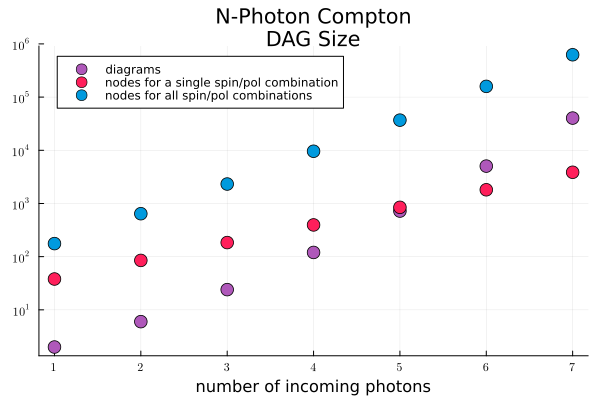

In [87]:
fig = scatter(
    [compton_df.diagrams compton_df.nodes compton_all_sp_df.nodes],
    yscale=:log10,
    seriescolor=[color3 color1 color2],
    label=["diagrams" "nodes for a single spin/pol combination" "nodes for all spin/pol combinations"],
    title="N-Photon Compton\nDAG Size",
    #ylabel="#",
    xlabel="number of incoming photons",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1, 2, 3, 4, 5, 6, 7], ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$", "\$6\$", "\$7\$"]),
    yticks=([1e1, 1e2, 1e3, 1e4, 1e5, 1e6], ["\$10^1\$", "\$10^2\$", "\$10^3\$", "\$10^4\$", "\$10^5\$", "\$10^6\$"])
)
savefig(fig, "compton_dag_sizes.pdf")
fig

ExpFit{Float64}((8.395317819698223, 0.7679946060001656))ExpFit{Float64}((10.55409759102669, 1.368432753959772))

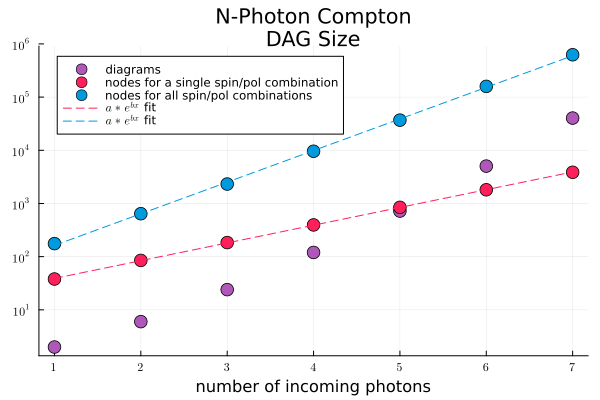

In [88]:
fig = scatter(
    [compton_df.diagrams compton_df.nodes compton_all_sp_df.nodes],
    yscale=:log10,
    seriescolor=[color3 color1 color2],
    label=["diagrams" "nodes for a single spin/pol combination" "nodes for all spin/pol combinations"],
    title="N-Photon Compton\nDAG Size",
    #ylabel="#",
    xlabel="number of incoming photons",
    markersize=7,
    legend_position=:topleft,
    #size=(600, 500),
    xticks=([1, 2, 3, 4, 5, 6, 7], ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$", "\$6\$", "\$7\$"]),
    yticks=([1e1, 1e2, 1e3, 1e4, 1e5, 1e6], ["\$10^1\$", "\$10^2\$", "\$10^3\$", "\$10^4\$", "\$10^5\$", "\$10^6\$"])
)

f_nodes_single = curve_fit(ExpFit, Float64.(2:8), Float64.(compton_df.nodes))
f_nodes_all = curve_fit(ExpFit, Float64.(2:8), Float64.(compton_all_sp_df.nodes))

show(f_nodes_single)
show(f_nodes_all)

plot!(1:0.05:7, f_nodes_single.(2:0.05:8), seriescolor=color1, label = "\$a*e^{bx}\$ fit", linestyle=:dash)
plot!(1:0.05:7, f_nodes_all.(2:0.05:8), seriescolor=color2, label = "\$a*e^{bx}\$ fit", linestyle=:dash)
savefig(fig, "compton_dag_sizes_expfit.pdf")
fig

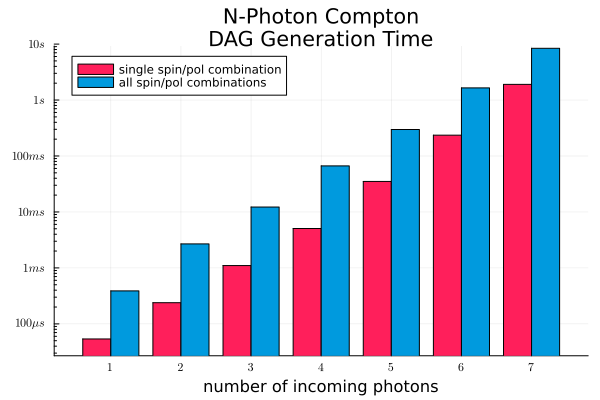

In [89]:
fig = groupedbar(
    ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$", "\$6\$", "\$7\$"],
    [(compton_df.t_med ./ 1e9) (compton_all_sp_df.t_med ./ 1e9)],
    #yerr = [(compton_df.t_std ./ 1e9) (compton_all_sp_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title = "N-Photon Compton\nDAG Generation Time",
    label = ["single spin/pol combination" "all spin/pol combinations"],
    xlabel = "number of incoming photons",
    yticks = ([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1],
        ["\$100μs\$", "\$1ms\$", "\$10ms\$", "\$100ms\$", "\$1s\$", "\$10s\$"]),
    yminorticks = true,
    yaxis=:log10, ylim=[0.5*min(compton_df.t_med...)/1e9, 1.1*max(compton_all_sp_df.t_med...)/1e9],
)
savefig(fig, "compton_dag_gen_time.pdf")
fig

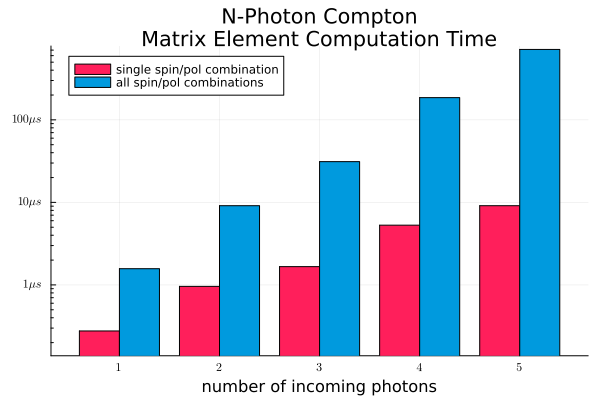

In [90]:
fig = groupedbar(
    ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$"],
    [(compton_exec_df.t_med[begin:5] ./ 1e9) (compton_exec_all_combs_df.t_med[begin:5] ./ 1e9)],
    #yerr = [(compton_exec_df.t_std ./ 1e9) (compton_exec_all_combs_df.t_std ./ 1e9)],
    seriescolor=[color1 color2],
    title="N-Photon Compton\nMatrix Element Computation Time",
    label=["single spin/pol combination" "all spin/pol combinations"],
    xlabel="number of incoming photons",
    yticks=([1e-6, 1e-5, 1e-4],
        ["\$1μs\$", "\$10μs\$", "\$100μs\$"]),
    yminorticks=true,
    yaxis=:log10,
    ylim=[0.5 * min(compton_exec_df.t_med[begin:5]...) / 1e9, 1.1 * max(compton_exec_all_combs_df.t_med[begin:5]...) / 1e9],
)
savefig(fig, "compton_exec_time.pdf")
fig

[176, 642, 2320, 9590, 36876]


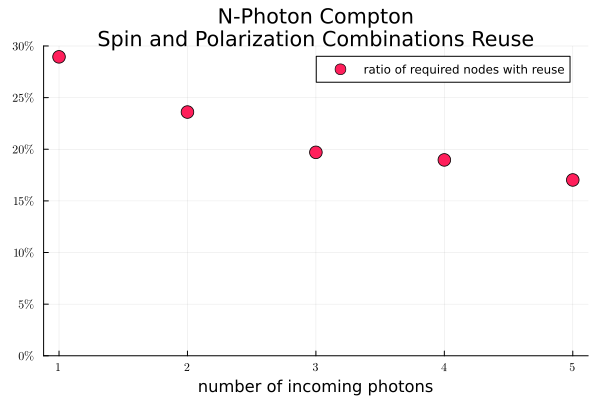

In [91]:
x = 1:5 # number of incoming photons
sp_combinations_total = compton_df.nodes[1:5] .* (2 .^(x.+3)) # nodes in naive approach (single combination * number of combinations)
combination_dag_scaling = compton_all_sp_df.nodes[1:5]

fig = scatter(
    x,
    100. .* combination_dag_scaling ./ sp_combinations_total,
    #yscale=:identity,
    ylim = (0, 30),
    seriescolor=color1,
    label="ratio of required nodes with reuse",
    title="N-Photon Compton\nSpin and Polarization Combinations Reuse",
    ylabel="",
    xlabel="number of incoming photons",
    markersize=7,
    legend_position=:topright,
    #size=(600, 500),
    xticks=([1, 2, 3, 4, 5, 6, 7], ["\$1\$", "\$2\$", "\$3\$", "\$4\$", "\$5\$", "\$6\$", "\$7\$"]),
    yticks=([0, 5, 10, 15, 20, 25, 30], ["\$0\\%\$", "\$5\\%\$", "\$10\\%\$", "\$15\\%\$", "\$20\\%\$", "\$25\\%\$", "\$30\\%\$"]),
    #yminorticks=true,
)
savefig(fig, "compton_combinations_scaling.pdf")
println(combination_dag_scaling)
fig